In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
from scipy.io import wavfile 
import os

## Generating Signal

In [2]:
## Set parameters
filename = "test.txt"
# Frequency encodings in Hz
low_freq = 1000
high_freq = 5103 # Chose something that's coprime with low_freq

fs = 44100 # Usually 44100 or 48000 fps 
t = .01
max_amp = 32767 # Because of signed 16 bit integers


In [3]:
#Import text and store as a string
contents = "" 
with open(filename, "r") as f: 
    contents = f.read() 
print("Contents as string: ", contents)

### Convert contents to binary string bin_contents 
bin_contents = "".join(format(ord(c), '08b') for c in contents) #08b means 0 pad and 8 length
print("Bit representation: ", bin_contents)

##Creating the "Sandwiche" Signal##

Flag =  '11100111'*10
bin_contents = Flag+bin_contents+Flag

# Generate wave 
wave = [] 
for b in bin_contents:
    if b == '0':
        freq = low_freq 
    elif b == '1':
        freq = high_freq 
    else:
        print(b)    
    waveform = np.sin(2 * np.pi * freq * np.arange(t * fs) / fs) 
    waveform_ints = np.int16(max_amp * waveform)
    wave = np.append(wave, waveform_ints)
print("Wave shape: ", np.shape(wave))


Contents as string:  Hello abcdefghijklmnopqrstuvwxyz

Bit representation:  010010000110010101101100011011000110111100100000011000010110001001100011011001000110010101100110011001110110100001101001011010100110101101101100011011010110111001101111011100000111000101110010011100110111010001110101011101100111011101111000011110010111101000001010
Wave shape:  (186984,)


In [4]:
### DOESNT WORK ON MACOS I THINK - CHANGE TO SD.PLAY
wavfile.write('first_gen.wav', fs, wave.astype(np.dtype('i2')))
# os.system("aplay first_gen.wav")


## Recording

In [5]:
## Set parameters 

fs = 44100 # Usually 44100 or 48000 fps 
duration = 5  # seconds
t = 0.01 # How many seconds each frequency plays for 
filename = 'first_gen.wav'

freq_0 = 1000 
freq_1 = 5103 
freq_error = 50

In [ ]:
# I'm using channels=1, most audio recording uses 2 channels because 
# of two headphone speakers (I think) but I think 1 channel is better 
# for plotting data

## JIANSHU, for testing type my_recording = sd play and rec here 

# fs, data = wavfile.read(filename)
# my_recording = sd.playrec(data,samplerate = 44100, channels=1,blocking=False)
# sd.wait()
# sd.stop()


my_recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()
sd.stop()

print("Shape of recording data: ", np.shape(my_recording))

print('Done recording')

wavfile.write(filename, fs, my_recording)

# Make sure `python -m sounddevice` or `sd.query_devices()` says
# you're connected to both *in* and *out* channels. 

## Post-Processing

In [44]:
# # Read the file - we'll have to change this to do while recording 
# # SOURCE: https://pythondsp.rob-elder.com/loading-wav-files-and-showing-frequency-response/
sample_rate, data = wavfile.read(filename) 
my_recording = data
print("Sample rate (should be same as fs): ", sample_rate)
print("Data shape (should be 1-dimensional): ", data.shape)
samples = data.shape[0]

Sample rate (should be same as fs):  44100
Data shape (should be 1-dimensional):  (220500,)


In [45]:
my_recording.shape

(220500,)

In [46]:
# plt.title("First 200 samples")
# plt.plot(my_recording[:1000])
# plt.show()

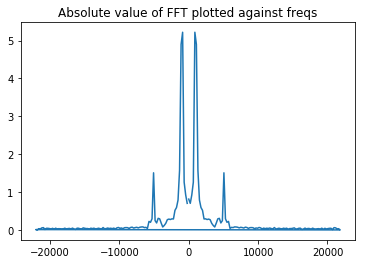

[11025.  11245.5 11466.  11686.5 11907.  12127.5 12348.  12568.5 12789.
 13009.5]


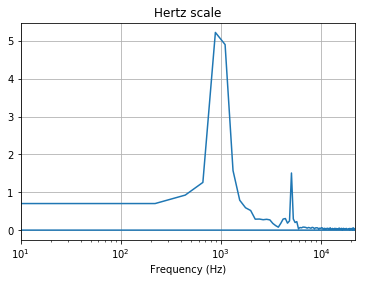

In [47]:
### This figures out frequencies for the *WHOLE* recording. 
sample_rate = 44100
data_fft = np.fft.fft(my_recording[:200])
fft_abs = abs(data_fft) 
freqs = np.fft.fftfreq(200, 1/sample_rate) 
plt.title("Absolute value of FFT plotted against freqs")
plt.plot(freqs, fft_abs)
plt.show() 

print(freqs[50:60])

# Let's use a better scale: the log scale which shows freqs in Hertz 
plt.xlim([10, sample_rate/2]) 
plt.xscale('log')
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.title('Hertz scale')
# The original example used freqs[:int(freqs.size/2)] but I don't 
# think it matters
plt.plot(freqs, fft_abs)
plt.show()

In [48]:
# print('Mode: ', freqs[np.argmax(fft_abs)])
# print('Index of mode: ', np.argmax(fft_abs))

# # We have to multiply by 5 to get correct index - I'm not sure why but below you can see that the mode index 
# # is 5 times the mode 
# print('Mass of 0 signal: ', max(fft_abs[(5 * freq_0 - freq_error):(5 * freq_0 + freq_error)]))
# print('Mass of 1 signal: ', max(fft_abs[(5 * freq_1 - freq_error):(5*freq_1 + freq_error)]))

Length of each chunks:  441
Number of chunks (should be duration / t):  500


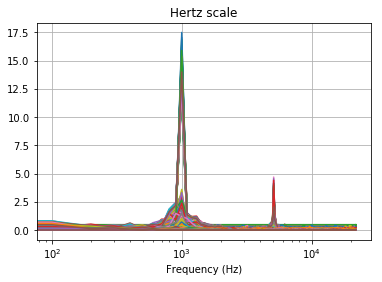

In [49]:
### This figures out frequencies for every interval of t seconds. 
### This is what we use to decode but it has to be perfectly 
### aligned with when the first signal starts. 

samp_p_chunk = int(t * fs)
start = int(0 * fs) # Index of frame when signal starts
# end = int(duration * fs) # Index of frame when signal stops
end = len(data)
chunks = [data[i:i + samp_p_chunk] 
          for i in range(start, end, samp_p_chunk)]
print('Length of each chunks: ', samp_p_chunk)
print('Number of chunks (should be duration / t): ', len(chunks)) 

result_bit_string = ""
for chunk in chunks: 
    c_fft = np.fft.fft(chunk)
    c_fft_abs = abs(c_fft)
    
    c_samples = chunk.shape[0]
    c_freqs = np.fft.fftfreq(c_samples, 1/sample_rate)
#     print(c_freqs)
        
    # Get maximum frequency from fft graph 
#     fig = plt.figure(figsize=(12,10))
#     plt.plot(c_freqs,c_fft_abs)
#     plt.xlim(0,10000)
    
    ### Here's a potential problem: the c_freqs array here has each entry differ by 100
    # c_freqs[50:60] is [5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900] but 
    # in the whole sample (ie the freqs array 2 cells above) it differs by .2 
    mass_0 = max(c_fft_abs[9:12])
#     mass_1 = max(c_fft_abs[12:15]) 
    mass_1 = max(c_fft_abs[50:53])
#     print(mass_0 > mass_1)

#NEED TO ADD THRESHOLD 
    if mass_0 > mass_1: 
        result_bit_string += '0'
    else: 
        result_bit_string += '1'


#     print(len(c_fft_abs))
#     print(len(c_freqs))
#     print(5 * freq_0 - freq_error)
#     print(5 * freq_0 + freq_error)
#     mass_0 = max(c_fft_abs[(5 * freq_0 - freq_error):(5 * freq_0 + freq_error)])
#     mass_1 = max(c_fft_abs[(5 * freq_1 - freq_error):(5 * freq_1 + freq_error)]) 
    
#     FFT for first chunk
    if chunk.all() == chunks[0].all():
        # plt.xlim([10, sample_rate/2]) 
        plt.xscale('log')
        plt.grid(True)
        plt.xlabel('Frequency (Hz)')
        plt.title('Hertz scale')
        plt.plot(c_freqs, c_fft_abs)

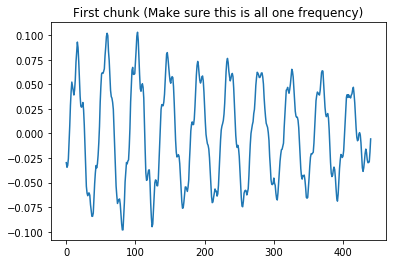

In [50]:
# Sanity check: plots first chunk so we know it captures a whole signal
plt.title("First chunk (Make sure this is all one frequency)")
plt.plot(chunks[0])
plt.show()

In [52]:
# chr(int(str(StrValue),2))

# assert(len(result_bit_string) % 8 == 0)
print(len(result_bit_string))
print("Recorded bit string: ", result_bit_string)

rec_mesg_bit_str = '010010000110010101101100011011000110111100100000011000010110001001100011011001000110010101100110011001110110100001101001011010100110101101101100011011010110111001101111011100000111000101110010011100110111010001110101011101100111011101111000011110010111101000001010'
decoded_string = "" 
for i in range(0, len(result_bit_string), 8):
    decoded_string += chr(int(result_bit_string[i:i+8], 2))
print(decoded_string)

500
Recorded bit string:  00000100011011000110111100100000011000010110001000100011011001000110010101100110011001110110000001101001011010100110101101101100011011010110111001100111011100000111000101100010011100110111010001110101011101100111011101111000011110010111101000001010000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000010000000100100000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000
lo ab#defg`ijklmngpqbstuvwxyz
           	                


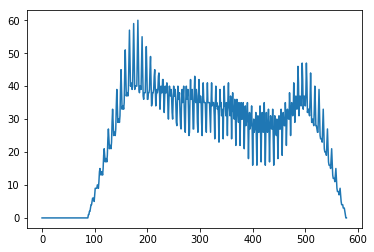

In [32]:
Flag_array = np.array([int(i) for i in list(Flag)])
result_bit_string_array = np.array([int(i) for i in list(result_bit_string)])
crocorr = np.correlate(Flag_array,result_bit_string_array,"full")
plt.plot(crocorr)

In [27]:
len(result_bit_string_array)

500

In [30]:
len(Flag_array)

80